In [47]:
import pymysql
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib qt5
%config InlineBackend.figure_format = 'svg'
time_unit = 1

In [48]:
conn = pymysql.connect(port=3306,user='root',passwd='220155',charset='utf8')
cursor = conn.cursor()
sql = 'use weibo_media'
cursor.execute(sql)
date_time_begin = '2020-1-03-10'
date_time_end = '2020-1-10-10'
date_time_begin = datetime.datetime.strptime(date_time_begin,'%Y-%m-%d-%H')
date_time_end = datetime.datetime.strptime(date_time_end,'%Y-%m-%d-%H')
def hot_1():
    begin = date_time_begin
    hot_num =[]
    hot_num.append(-1)
    while(begin<date_time_end):
        end = begin + datetime.timedelta(hours=time_unit)
        sql = f'select sum(forward_num)+sum(comment_num)+sum(like_num) from post where post_time>=\'{str(begin)}\' and post_time<\'{end}\' order by post_time'
        cursor.execute(sql)
        data = cursor.fetchall()
        if not data[0][0]:
            hot = 0
        else:
            #print(data[0][0])
            hot = np.log(int(data[0][0]))
        hot_num.append(hot)
        begin = end
    return hot_num
def hot_2():
    begin = date_time_begin
    hot_num =[]
    hot_num.append(-1)
    while(begin<date_time_end):
        end = begin + datetime.timedelta(hours=time_unit)
        sql = f'select forward_num+comment_num+like_num from post where post_time>=\'{str(begin)}\' and post_time<\'{end}\' order by post_time'
        cursor.execute(sql)
        data = cursor.fetchall()
        if not data:
            hot = 0
        else:
            data = [i[0]+1 for i in data]
            data = np.log(data)
            hot = np.sum(data)
        hot_num.append(hot)
        begin = end
    return hot_num
def hot_3():
    begin = date_time_begin
    hot_num =[]
    hot_num.append(-1)
    while(begin<date_time_end):
        end = begin + datetime.timedelta(hours=time_unit)
        sql = f'select forward_num+comment_num+like_num from post where post_time>=\'{begin}\' and post_time<\'{end}\' order by post_time'
        cursor.execute(sql)
        data = cursor.fetchall()
        #print(data)
        if not data:
            hot = 0
        else:
            data = [i[0]+1 for i in data]
            data = np.log(data)
            var = np.var(data)
            hot_sum = np.sum(data)
            num = len(data)
            hot = (var+1)/num*hot_sum
        hot_num.append(hot)
        begin = end
    return hot_num
def show_hot(hot_num):
    plt.figure()
    plt.xticks(range(len(hot_num)))
    plt.plot(hot_num)
    plt.show()

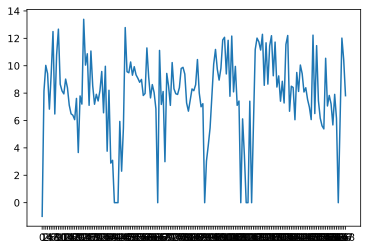

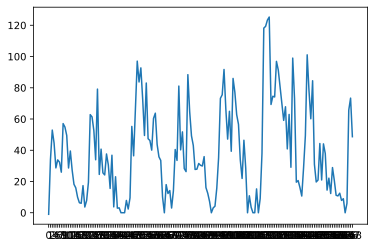

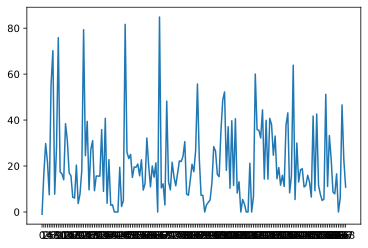

In [23]:
show_hot(hot_1())

show_hot(hot_2())

show_hot(hot_3())

In [49]:
def peak_windows_find_1(hot_num):
    def update(oldmean,oldmeandev,updatevalue):
        a = 0.8
        diff = np.abs(oldmean-updatevalue)
        newmeandev = a*diff+(1-a)*oldmeandev
        newmean = a*updatevalue+(1-a)*oldmean
        return newmean,newmeandev
    windows = []
    time_windows = []
    mean = hot_num[1]
    meandev = np.sum(np.abs(hot_num[1:4]-np.mean(hot_num[1:4])))/len(hot_num[1:4])
    thr1 = 1.5
    thr2 = 2
    i = 2
    while(i<len(hot_num)):
        if np.abs(hot_num[i]-mean)/meandev>thr1 and hot_num[i]>hot_num[i-1]:
            start = i-1
            while i<len(hot_num) and hot_num[i]>hot_num[i-1]:
                mean,meandev = update(mean,meandev,hot_num[i])
                i = i+1
            if i<len(hot_num) and hot_num[i]>hot_num[start]:
                while i<len(hot_num) and hot_num[i]>hot_num[start]:
                    if np.abs(hot_num[i]-mean)/meandev>thr2 and hot_num[i]>hot_num[i-1]:
                        i = i-1
                        end = i
                        time_end = date_time_begin+datetime.timedelta(hours=end*time_unit)
                        break
                    else:
                        mean,meandev = update(mean,meandev,hot_num[i])
                        end=i
                        i = i+1
            else:
                end = i
                
            if start<end:
                event_bin = []
                event_bin.extend([start,end])
                windows.append(event_bin)
                time_start = date_time_begin+datetime.timedelta(hours=(start-1)*time_unit)
                time_end = date_time_begin+datetime.timedelta(hours=end*time_unit)
                time_event_bin = []
                time_event_bin.extend([time_start,time_end])
                time_windows.append(time_event_bin)
        else:
            mean,meandev = update(mean,meandev,hot_num[i])
        i = i+1
    return mean,windows,time_windows
def peak_windows_find_2(hot_num):
    windows = []
    time_windows = []
    mean = np.mean(hot_num)
    th1 = 1.5
    th2 = 0.7
    peak = 0
    i = 2 
    while(i<len(hot_num)):
        if not peak and hot_num[i]>hot_num[i-1] and hot_num[i]>=th1*mean:
            start = i-1
            time_start = date_time_begin+datetime.timedelta(hours=(start-1)*time_unit)
            peak = hot_num[i]
        if peak:
            if hot_num[i]<peak*th2:
                end = i
                time_end = date_time_begin+datetime.timedelta(hours=start*time_unit)
                peak = 0
                event_bin = []
                event_bin.extend([start,end])
                windows.append(event_bin)
                time_event_bin = []
                time_event_bin.extend([time_start,time_end])
                time_windows.append(time_event_bin)
        i = i+1
    return mean,windows,time_windows

In [51]:
def show_peak(mean,hot_num,windows):
    plt.figure()
    plt.xticks(range(0,len(hot_num)))
    plt.plot(hot_num)
    for v in windows:
        plt.plot(range(v[0],v[1]+1),[mean for i in range(v[0],v[1]+1)])
        plt.gca().add_patch(plt.Rectangle(xy=[v[0],mean],width=v[1]-v[0],height=mean/2,fill=False,lw=3,color='r'))
    plt.show()

In [52]:
def peak_find_show(hot_,peak_windows_find_):
    hot_num = hot_()
    mean,windows,time = peak_windows_find_(hot_num)
    show_peak(mean,hot_num,windows)

In [59]:
def peak_find_text_show(hot_,peak_windows_find_):
    hot_num = hot_()
    mean,windows,time = peak_windows_find_(hot_num)
    for t in time:
        begin = t[0]
        end = t[-1]
        sql = f'select post_content from post where post_time>=\'{begin}\' and post_time<\'{end}\' order by post_time'
        cursor.execute(sql)
        data = cursor.fetchall()
        for i in data:
            print(i[-1])
            print('*'*10)
        print(begin)
        print(data)
        print(end)
        print('-'*120)
        print()
def show_all():
    begin = date_time_begin
    while(begin<date_time_end):
        end = begin + datetime.timedelta(hours=1)
        sql = f'select post_content from post where post_time>=\'{begin}\' and post_time<\'{end}\' order by post_time'
        cursor.execute(sql)
        data = cursor.fetchall()
        for i in data:
            value = i[-1]
            print(type(value))
            print(i[-1])
            print(''*10)
        print(begin)
        print(end)
        print('-'*150)
        print()
        begin = end

In [60]:
peak_find_text_show(hot_1,peak_windows_find_1)

<#>#每经整点播#</#>【每经10点美国承认对巴格达两处与伊朗有关的目标发动袭击；比尔盖茨的新年愿望：让我和其他亿万富翁多缴税；戈恩：逃离日本是我一个人策划的，没有家庭成员参与】1、美国承认对巴格达两处与伊朗有关的目标发动袭击。环球时报援引路透社刚刚消息称，美国官员证实，美国周五对巴格达两处与伊朗有关的目标发动了袭击。路透社还称，一位伊拉克民兵组织发言人说，一名伊朗高级指挥官和一名伊拉克民兵组织指挥官被杀。2、戈恩发声明：逃离日本是我一个人策划的，没有家庭成员参与。澎湃新闻援引外媒报道，日产汽车前董事长卡洛斯·戈恩（CarlosGhosn）发表声明称，其逃往黎巴嫩的计划是一个人策划的，家庭成员在其中没有扮演任何角色。戈恩现年65岁，黎巴嫩裔，出生于巴西，获得法国和黎巴嫩国籍。戈恩目前在日本面临漏报巨额收入，向日产转嫁个人投资损失等4项指控。日本法院原定2020年4月开庭审理戈恩一案。但在庭审前，戈恩出走了。O每经10点美国承认对巴格达两处与伊朗有关的目标发动袭击；比尔盖茨的新年愿望：让我和其他亿万富翁多缴税；戈恩：逃离日本是我一个人策划的，没有家庭成员参与O每经10点美国承认对巴格达两处与伊朗有关的目标发动袭击
**********
【外媒：美国声称在巴格达发动“与伊朗有关的”袭击】据路透社报道，美国证实，疑与伊朗有关的巴格达机场袭击系美国所为。当地时间3日凌晨，三枚火箭弹落在伊拉克首都巴格达国际机场附近，爆炸造成至少8人死亡，12名伊拉克军人受伤。<u>O外媒：美国声称在巴格达发动“与伊朗有关的”袭击:['http://t.cn/AisU8RQj']</u>
**********
【伊朗特种部队指挥官伊拉克遭火箭弹袭击身亡，外媒：美国声称在巴格达发动“与伊朗有关的”袭击】当地时间周五，伊拉克巴格达附近遭不明火箭弹袭击，导致伊拉克什叶派民兵武装“人民动员组织”5名成员死亡，包括该组织副指挥官，此外，还有两名该组织重要“伊朗客人”死亡，据中东媒体等报道，两名客人中包括伊朗伊斯兰革命卫队下属特种部队“圣城旅”旅长卡西姆∙苏莱曼尼。目前未有组织和个人宣布对此起袭击负责，但英媒援引消息人士的话报道称，美军当天空袭了巴格达两个与伊朗有联系的目标。最新消息，据路透社报道，美国证实，疑与伊朗有关的巴格达机场袭击系美国所为。当地时间3日凌晨，三枚火箭弹落在伊拉克首都巴格达国际机

In [46]:
show_all()

<class 'str'>
<#>#每经整点播#</#>【每经10点美国承认对巴格达两处与伊朗有关的目标发动袭击；比尔盖茨的新年愿望：让我和其他亿万富翁多缴税；戈恩：逃离日本是我一个人策划的，没有家庭成员参与】1、美国承认对巴格达两处与伊朗有关的目标发动袭击。环球时报援引路透社刚刚消息称，美国官员证实，美国周五对巴格达两处与伊朗有关的目标发动了袭击。路透社还称，一位伊拉克民兵组织发言人说，一名伊朗高级指挥官和一名伊拉克民兵组织指挥官被杀。2、戈恩发声明：逃离日本是我一个人策划的，没有家庭成员参与。澎湃新闻援引外媒报道，日产汽车前董事长卡洛斯·戈恩（CarlosGhosn）发表声明称，其逃往黎巴嫩的计划是一个人策划的，家庭成员在其中没有扮演任何角色。戈恩现年65岁，黎巴嫩裔，出生于巴西，获得法国和黎巴嫩国籍。戈恩目前在日本面临漏报巨额收入，向日产转嫁个人投资损失等4项指控。日本法院原定2020年4月开庭审理戈恩一案。但在庭审前，戈恩出走了。O每经10点美国承认对巴格达两处与伊朗有关的目标发动袭击；比尔盖茨的新年愿望：让我和其他亿万富翁多缴税；戈恩：逃离日本是我一个人策划的，没有家庭成员参与O每经10点美国承认对巴格达两处与伊朗有关的目标发动袭击
**********
<class 'str'>
【外媒：美国声称在巴格达发动“与伊朗有关的”袭击】据路透社报道，美国证实，疑与伊朗有关的巴格达机场袭击系美国所为。当地时间3日凌晨，三枚火箭弹落在伊拉克首都巴格达国际机场附近，爆炸造成至少8人死亡，12名伊拉克军人受伤。<u>O外媒：美国声称在巴格达发动“与伊朗有关的”袭击:['http://t.cn/AisU8RQj']</u>
**********
<class 'str'>
【伊朗特种部队指挥官伊拉克遭火箭弹袭击身亡，外媒：美国声称在巴格达发动“与伊朗有关的”袭击】当地时间周五，伊拉克巴格达附近遭不明火箭弹袭击，导致伊拉克什叶派民兵武装“人民动员组织”5名成员死亡，包括该组织副指挥官，此外，还有两名该组织重要“伊朗客人”死亡，据中东媒体等报道，两名客人中包括伊朗伊斯兰革命卫队下属特种部队“圣城旅”旅长卡西姆∙苏莱曼尼。目前未有组织和个人宣布对此起袭击负责，但英媒援引消息人士的话报道称，美军当天空袭了巴格达两个与伊朗有联系的目标。最新消息，据路透社报道，美国证实，疑与伊朗有

<class 'str'>
【美国防长：美国已做好和伊朗打完任何战争的准备】当地时间1月7日，美国国防部长埃斯珀表示，美国希望缓和与伊朗的紧张关系，但已做好打完一场战争的准备。随后，埃斯珀还补充：“我们希望看到局势能有所缓和。”<u>LBTV特别关注的微博视频:['http://t.cn/AisormHd']</u>
**********
<class 'str'>
【<#>#美伊紧张引发黄金市场波动#</#>】自美国发动空袭杀死伊朗将军苏莱马尼后，中东地区安全局势呈高度紧张，中东黄金市场剧烈波动。3日苏莱马尼被杀当天，迪拜22K金价格跳涨到每克176.5迪拉姆，创2018年1月来新高。4日更上涨到每克179迪拉姆、约合人民币338元。<#>#黄金原油大涨#</#>（人民日报）<u>L人民日报的微博视频:['http://t.cn/AisoV6Aa']</u>
**********
<class 'str'>
【美伊冲突升级<#>#多家航空公司绕开伊朗航线#</#>】北京时间今天凌晨，美军驻伊拉克空军基地遭火箭弹袭击。美国FAA已经发布预警，禁止美国的民航班机从伊朗，伊拉克以及波斯湾和阿曼湾水域上空飞越。不少欧洲航司已经开始将常规飞经伊朗上空的航路改为绕开伊朗和伊拉克。另外新加坡航空也绕开伊朗航线。阿联酋航空因运营原因取消飞往巴格达的航班。澳大利亚航空改变航线，避开伊拉克和伊朗空域。记者查阅实时雷达追踪软件发现，目前，除伊朗本国航司、由伊朗起降的国际航班外，土耳其航空、印尼鹰航、马航，及中东地区、俄罗斯、乌克兰等国家的航司仍在使用伊朗空域。（第一财经）
**********
<class 'str'>
【伊朗展开复仇接下来会怎样？】伊朗军方重要人物卡西姆•苏莱曼尼3日被美军定点清除后，伊朗8日开始动手报复。从媒体报道看，伊朗此次军事行动具有规模有限、目标明确、意图明显等特点。下阶段，伊朗有哪些选项，美国将如何应对？美伊之间紧张态势是否已无可挽回？详情请戳<u>O伊朗展开复仇:['http://t.cn/Aisodk6E']</u>
**********
<class 'str'>
【特朗普回应驻伊美军基地遭伊朗袭击】美国总统特朗普当地时间1月7日通过推特对驻伊美军基地遇袭一事做出回应，特朗普表示：“一切安好，发射自伊朗的导弹袭击美军两处在伊拉克的基地，人员伤亡和损失

In [57]:
peak_find_show(hot_1,peak_windows_find_1)
peak_find_show(hot_1,peak_windows_find_2)

In [58]:
peak_find_show(hot_2,peak_windows_find_1)
peak_find_show(hot_2,peak_windows_find_2)

In [59]:
peak_find_show(hot_3,peak_windows_find_1)
peak_find_show(hot_3,peak_windows_find_2)